# Fully Quantum 2–Level Nondecimated Haar Example (Qiskit 2.x)

This notebook demonstrates a small but complete example of a **fully quantum nondecimated Haar transform** (QNDWT) for a length 8 signal. The goal is to reproduce the classical 2–level NDWT coefficients using a single quantum circuit with ancilla qubits that encode circular shifts.

We work with

- Data size: $N = 8$ (three data qubits)
- Levels: $L = 2$ (two ancilla qubits, shifts $\varepsilon = 0,1,2,3$)
- Wavelet: 2–level Haar transform

The notebook is organized so that every quantum step has a clear classical counterpart, making it easy to verify correctness.

---

## 1. Data preparation and amplitude encoding

We start with a short real signal

$$
d = [2, 1, 9, 0, 3, -10, 2, 4].
$$

First, $d$ is rescaled linearly to the interval $[-1, 1]$ and then normalized to unit Euclidean norm. This produces the amplitude vector

$$
y = \frac{d_{\text{scaled}}}{\|d_{\text{scaled}}\|},
$$

which is used to prepare the quantum data register. In the code, this vector is stored as `d_amp`. The mapping is

$$
|y\rangle = \sum_{k=0}^{7} y_k \, |k\rangle,
$$

on three data qubits.

---

## 2. Classical NDWT style reference

Before going to the quantum implementation, we build a **purely classical reference** for the nondecimated Haar transform.

1. We define simple circular convolution `circ_conv(x,f)` and a MODWT style upsampling `upsample_filter(base,j)`.

2. Using the Haar analysis filters $h$ and $g$, we compute a 2–level nondecimated transform in two ways:

   - Direct MODWT style convolution:
     - Level 1 details: $w_1^{\text{ref}} = g^{(1)} \circledast y$
     - Level 1 approximation: $v_1 = h^{(1)} \circledast y$
     - Level 2 details: $w_2^{\text{ref}} = g^{(2)} \circledast v_1$
     - Level 2 approximation: $a_2^{\text{ref}} = h^{(2)} \circledast v_1$

   Here $g^{(j)}$ and $h^{(j)}$ are the level dependent upsampled filters.

3. In parallel, we construct a **classical 2–level Haar DWT matrix** $W$ of size $8 \times 8$. Each column of $W$ is the 2–level Haar transform of a coordinate basis vector. The coefficient ordering is

$$
[a_2(0), a_2(1), d_2(0), d_2(1), d_1(0), d_1(1), d_1(2), d_1(3)].
$$

We verify that $W$ is essentially orthogonal by checking

$$
\|W^T W - I\|_F \approx 0.
$$

This matrix allows us to compute decimated Haar coefficients for any input by a single matrix multiplication.

---

## 3. Classical NDWT via circular shifts

To emulate the NDWT structure from an orthogonal DWT, we follow the standard “shift–sum” procedure:

1. For each circular shift $\varepsilon \in \{0,1,2,3\}$ we define a permutation matrix $S_{\varepsilon}$ that rotates the signal by $\varepsilon$ positions.

2. For each $\varepsilon$ we compute decimated coefficients

$$
\text{coeff}_{\varepsilon} = W S_{\varepsilon} y,
$$

and split them into

- $a_2^{(\varepsilon)}$ (length 2, approximation)
- $d_2^{(\varepsilon)}$ (length 2, level 2 details)
- $d_1^{(\varepsilon)}$ (length 4, level 1 details)

3. To build nondecimated sequences, we “place and unshift” these decimated vectors:

   - For a decimated vector of length 4 (level 1) we place entries on indices $\{0,2,4,6\}$ (stride 2) and then circularly unshift by $\varepsilon$.
   - For a decimated vector of length 2 (level 2) we place entries on $\{0,4\}$ (stride 4) and unshift.

The helper `place_and_unshift(vec_dec, stride, N, eps)` does this placement and inverse shift. Summing over all shifts and including the appropriate level factors, we obtain

$$
w_1^{\text{cl}}, \quad w_2^{\text{cl}}, \quad a_2^{\text{cl}},
$$

the classical NDWT sequences for level 1 details, level 2 details, and level 2 approximation.

These arrays serve as the **ground truth** for the quantum qNDWT.

---

## 4. Fully quantum QNDWT circuit

We now construct the fully quantum nondecimated Haar transform using Qiskit 2.x.

### 4.1 Registers and structure

- Two ancilla qubits encode the shift index $\varepsilon \in \{0,1,2,3\}$.
- Three data qubits encode the signal in amplitude form.

The total Hilbert space has dimension

$$
2^2 \times 2^3 = 2^5 = 32.
$$

### 4.2 Uniform shift superposition

The ancilla register is prepared in a uniform superposition

$$
\frac{1}{2} \sum_{\varepsilon=0}^{3} |\varepsilon\rangle_{\text{anc}}.
$$

The data register is initialized in $|y\rangle$ built from `d_amp`. The initial state is therefore

$$
|\Psi_0\rangle
=
\frac{1}{2}\sum_{\varepsilon=0}^{3} |\varepsilon\rangle \otimes |y\rangle.
$$

### 4.3 Controlled circular shifts on the data

For each shift value $\varepsilon$, we define a unitary permutation matrix

$$
S_{\varepsilon} : |k\rangle \mapsto |(k+\varepsilon) \bmod 8\rangle,
$$

and promote it to a multi controlled gate that acts on the data register only when the ancilla is in the basis state $|\varepsilon\rangle$.

The helper function `apply_shift_controlled(qc, anc, data, eps)` implements this by:

- Encoding $\varepsilon$ in binary on the ancilla, with `anc[0]` as the least significant bit.
- Using $X$ gates to flip control qubits so the multi controlled operation triggers only on the pattern corresponding to $\varepsilon$.
- Applying the controlled unitary $S_{\varepsilon}$ on the data qubits.

After applying all four controlled shifts, the state becomes

$$
|\Psi_1\rangle
=
\frac{1}{2}\sum_{\varepsilon=0}^{3} |\varepsilon\rangle \otimes S_{\varepsilon}|y\rangle.
$$

### 4.4 Two–level Haar transform on the data

We then append a single block corresponding to the 2–level Haar transform, represented as the unitary $W$ on the data register:

$$
|\Psi_2\rangle
=
\frac{1}{2}\sum_{\varepsilon=0}^{3} |\varepsilon\rangle \otimes W S_{\varepsilon}|y\rangle.
$$

Here, $W$ is exactly the same 8 by 8 Haar matrix used in the classical computation. Its action produces the decimated coefficients

$$
\text{coeff}_{\varepsilon} = W S_{\varepsilon} y,
$$

now encoded in the computational basis of the data qubits.

This is the **fully quantum QNDWT** state for two levels and four shifts.

---

## 5. Extracting Haar coefficients from the statevector

The circuit is simulated with `Statevector.from_instruction(qc)`, giving the full 5 qubit state $|\Psi_2\rangle$.

Qiskit uses a fixed qubit ordering in the computational basis. With ancilla qubits first and data qubits next, the basis index can be written as

$$
\text{index} = \text{ancilla\_index} + 4 \cdot \text{data\_index},
$$

since there are $2^2 = 4$ ancilla states and $2^3 = 8$ data states.

For a fixed $\varepsilon$ we collect amplitudes

$$
\{ \Psi_2(\varepsilon, k) : k = 0,\dots,7 \},
$$

and then rescale them by the factor $\sqrt{4}\,\|y\|$ so that they match the classical coefficients, because

- the ancilla superposition contributes a factor $1/2$,
- the data register was initialized with $y / \|y\|$.

The resulting vectors are

- $a_2^{(\varepsilon)}$ (first 2 entries),
- $d_2^{(\varepsilon)}$ (next 2 entries),
- $d_1^{(\varepsilon)}$ (last 4 entries),

stored in the dictionaries `a2_eps_q`, `d2_eps_q`, and `d1_eps_q`.

---

## 6. Quantum NDWT assembly and comparison

We reconstruct the nondecimated sequences from the quantum derived decimated coefficients by repeating exactly the same “place and unshift” logic as in the classical case:

$$
w_1^{\text{q}} = \sum_{\varepsilon=0}^{3}
    \text{place\_and\_unshift}\bigl(d_1^{(\varepsilon)}, \text{stride}=2, \varepsilon\bigr) \cdot 2^{-1},
$$

$$
w_2^{\text{q}} = \sum_{\varepsilon=0}^{3}
    \text{place\_and\_unshift}\bigl(d_2^{(\varepsilon)}, \text{stride}=4, \varepsilon\bigr),
$$

$$
a_2^{\text{q}} = \sum_{\varepsilon=0}^{3}
    \text{place\_and\_unshift}\bigl(a_2^{(\varepsilon)}, \text{stride}=4, \varepsilon\bigr).
$$

The final arrays `w1_q`, `w2_q`, and `a2_q` are the **fully quantum NDWT outputs**, reconstructed from the single qNDWT state.

We then compute relative errors

$$
\text{rel\_err}(x,y)
=
\frac{\|x - y\|_2}{\|y\|_2 + 10^{-15}},
$$

for each of

- $w_1^{\text{q}}$ vs $w_1^{\text{cl}}$,
- $w_2^{\text{q}}$ vs $w_2^{\text{cl}}$,
- $a_2^{\text{q}}$ vs $a_2^{\text{cl}}$.

Small relative errors confirm that the qNDWT implementation reproduces the classical NDWT exactly (up to numerical precision).

---

## 7. Interpretation

This example shows explicitly that:

1. A single quantum circuit with a small ancilla register can coherently implement several circular shifts and a multilevel Haar transform at once.

2. The final state encodes, in superposition, the decimated Haar coefficients for all shifts, from which the nondecimated sequences can be recovered.

3. The correspondence between quantum and classical coefficients is exact, including all normalization constants, and can be checked coefficient by coefficient.

This construction forms a building block for more advanced examples, such as:

- deeper levels ($L > 2$),
- larger data registers ($N > 8$),
- smooth wavelets implemented by Givens rotations,
- subsequent quantum operations on the NDWT coefficients (for shrinkage, correlation, and other tasks).


In [2]:
# ============================================================
# Qiskit 2.x — Fully quantum 2-level ND Haar (4 shifts) example
# ============================================================

import numpy as np
from math import sqrt

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import UnitaryGate

# Optional (for circuit drawing / plots)
import matplotlib.pyplot as plt
# %matplotlib inline

# ------------------------
# 1) Data preparation
# ------------------------
dd = np.array([2, 1, 9, 0, 3, -10, 2, 4], dtype=float)

# Normalize to [-1,1] then amplitude-normalize
d_scaled = 2 * (dd - dd.min()) / (dd.max() - dd.min()) - 1
print("Scaled (to [-1,1]) data:", np.round(d_scaled, 6))

norm_y = np.linalg.norm(d_scaled)
y = d_scaled.copy()
d_amp = y / norm_y
print("Amplitude-encoded vector (normalized):", np.round(d_amp, 6))

N = y.size           # 8
n_data = 3           # 3 data qubits (2^3 = 8)
L = 2                # 2 ancilla qubits => 4 shifts (ε = 0..3)

# ============================================================
# 2) Classical helpers: MODWT-style reference NDWT
# ============================================================

def circ_conv(x, f):
    """Circular convolution of x with short filter f."""
    n = x.size
    m = f.size
    out = np.zeros(n, dtype=float)
    for k in range(n):
        s = 0.0
        for t in range(m):
            s += x[(k - t) % n] * f[t]
        out[k] = s
    return out

def upsample_filter(base, j):
    """Upsample 'base' filter for level j (Haar MODWT style)."""
    if j == 1:
        return base.copy()
    z = np.zeros((base.size - 1) * (2**(j-1)) + 1, dtype=float)
    z[::2**(j-1)] = base
    return z

# Haar analysis filters
h = np.array([1.0, 1.0]) / sqrt(2.0)
g = np.array([-1.0, 1.0]) / sqrt(2.0)

# Classical MODWT-style reference for y
v0 = y.copy()
w1_ref = circ_conv(v0, upsample_filter(g, 1))
v1 = circ_conv(v0, upsample_filter(h, 1))
w2_ref = circ_conv(v1, upsample_filter(g, 2))
a2_ref = circ_conv(v1, upsample_filter(h, 2))

print("\nReference MODWT-style outputs:")
print("a2^(ref):", np.round(a2_ref, 6))
print("d2^(ref):", np.round(w2_ref, 6))
print("d1^(ref):", np.round(w1_ref, 6))

# ============================================================
# 3) Classical Haar DWT matrix (2-level) for N=8
# ============================================================

def haar_level_mats(n):
    half = n // 2
    A = np.zeros((half, n), dtype=float)
    D = np.zeros((half, n), dtype=float)
    inv = 1.0 / sqrt(2.0)
    for k in range(half):
        i0, i1 = 2*k, 2*k+1
        A[k, i0] = inv; A[k, i1] = inv
        D[k, i0] = inv; D[k, i1] = -inv
    return A, D

def dwt_matrix_2levels_haar(N=8):
    assert N == 8
    W = np.zeros((N, N), dtype=float)
    I = np.eye(N, dtype=float)
    for i in range(N):
        s = I[:, i]
        A1, D1 = haar_level_mats(N)
        a1 = A1 @ s
        d1 = D1 @ s
        A2, D2 = haar_level_mats(N//2)
        a2 = A2 @ a1
        d2 = D2 @ a1
        coeff = np.concatenate([a2, d2, d1])  # [a2(2), d2(2), d1(4)]
        W[:, i] = coeff
    fro_err = np.linalg.norm(W.T @ W - np.eye(N), ord='fro')
    print("\n||W^T W - I||_F =", float(fro_err))
    return W

W = dwt_matrix_2levels_haar(8)

# ============================================================
# 4) Classical NDWT assembly via circular shifts (for reference)
# ============================================================

def circ_shift_matrix(N, eps):
    P = np.zeros((N, N), dtype=float)
    for i in range(N):
        P[(i+eps) % N, i] = 1.0
    return P

# Compute 2-level Haar DWT for each shift ε = 0..3
a2_eps_cl = {}
d2_eps_cl = {}
d1_eps_cl = {}

for eps in [0, 1, 2, 3]:
    S = circ_shift_matrix(N, eps)
    coeff = W @ (S @ y)
    a2_eps_cl[eps] = coeff[0:2].copy()
    d2_eps_cl[eps] = coeff[2:4].copy()
    d1_eps_cl[eps] = coeff[4:8].copy()

def place_and_unshift(vec_dec, stride, N, eps):
    """
    Place decimated vector on indices {0, stride, 2*stride,...}
    then circularly unshift by eps.
    """
    out = np.zeros(N, dtype=float)
    k = 0
    for n in range(0, N, stride):
        out[n] = vec_dec[k]
        k += 1
    return np.roll(out, -eps)

# NDWT assembly
w1_cl = np.zeros(N, dtype=float)
w2_cl = np.zeros(N, dtype=float)
a2_cl = np.zeros(N, dtype=float)

for eps in [0, 1, 2, 3]:
    w1_cl += place_and_unshift(d1_eps_cl[eps], stride=2, N=N, eps=eps) / 2.0  # j=1, factor 2^{-j/2}
    w2_cl += place_and_unshift(d2_eps_cl[eps], stride=4, N=N, eps=eps)        # j=2
    a2_cl += place_and_unshift(a2_eps_cl[eps], stride=4, N=N, eps=eps) 

print("\nClassical NDWT (via Haar+shifts) for y:")
print("w1_cl:", np.round(w1_cl, 6))
print("w2_cl:", np.round(w2_cl, 6))
print("a2_cl:", np.round(a2_cl, 6))

# ============================================================
# 5) Fully quantum QNDWT circuit in Qiskit 2.x
# ============================================================

# 5.1 Unitary gate for 2-level Haar on 3 data qubits
W_gate = UnitaryGate(Operator(W), label="W_Haar2")

# 5.2 Unitary gates for circular shifts on data register
def circ_shift_unitary(N, eps):
    """N x N unitary for circular shift by eps (permutation matrix)."""
    U = np.zeros((N, N), dtype=complex)
    for k in range(N):
        U[(k + eps) % N, k] = 1.0
    return U

def apply_shift_controlled(qc, anc, data, eps):
    """
    Apply S_eps on 'data' controlled on ancilla being in basis state |eps>.
    Implementation:
      - compute bit pattern of eps in {0,1}^L (LSB on anc[0])
      - X on ancilla qubits where bit=0 so that |eps> is mapped to |11...1>
      - apply multi-controlled S_eps with all controls on '1'
      - undo the X's
    """
    if eps == 0:
        # Shift by 0 is identity, nothing to do
        return

    U_eps = circ_shift_unitary(2**n_data, eps)
    S_eps = UnitaryGate(Operator(U_eps), label=f"S_{eps}")
    S_ctrl = S_eps.control(num_ctrl_qubits=L)

    # Binary pattern of eps with anc[0] as least significant bit
    bits = [(eps >> j) & 1 for j in range(L)]

    # To control on |eps>, flip ancilla qubits where bit is 0
    for j, b in enumerate(bits):
        if b == 0:
            qc.x(anc[j])
    qc.append(S_ctrl, anc[:] + data[:])
    for j, b in enumerate(bits):
        if b == 0:
            qc.x(anc[j])

# 5.3 Build the qNDWT circuit
anc = QuantumRegister(L, 'anc')
data = QuantumRegister(n_data, 'data')
qc = QuantumCircuit(anc, data, name="QNDWT")

# 1) Prepare ancilla in uniform superposition over ε = 0..3
for q in anc:
    qc.h(q)

qc.barrier(label="ancilla_H")

# 2) Initialize data register in amplitude-encoded |y> = y / ||y||
qc.initialize(d_amp, data)

qc.barrier(label="init_data")

# 3) Controlled circular shifts: for each ε, apply S_ε on data controlled on ancilla = |ε>
for eps in [0, 1, 2, 3]:
    apply_shift_controlled(qc, anc, data, eps)

qc.barrier(label="controlled_shifts")

# 4) Apply 2-level Haar transform on data register
qc.append(W_gate, data[:])

qc.barrier(label="Haar2")

print("\nqNDWT circuit (text):")
print(qc.draw(fold=-1))

# Nicer Matplotlib plot (in Jupyter this shows the circuit figure)
qc.draw(output="mpl", fold=-1)
plt.show()

# ============================================================
# 6) Extract coefficients from the quantum statevector
# ============================================================

# Statevector for the full 5-qubit system (2 anc + 3 data)
sv = Statevector.from_instruction(qc)
psi = sv.data

# Qiskit qubit ordering:
# qubit indices: anc[0]=0, anc[1]=1, data[0]=2, data[1]=3, data[2]=4
# Basis index = b0*2^0 + b1*2^1 + ... + b4*2^4
# so ancilla index e = anc0 + 2*anc1, data index k = data0 + 2*data1 + 4*data2
# => global index = e + 4*k

# Reconstruct classical 2-level Haar coefficients for each eps from amplitudes.
# Overall factor: |Ψ> = (1/sqrt(4)) Σ_ε |ε> ⊗ W S_ε |y/||y||>
# so coeff_{ε,k} = amplitude * sqrt(4) * ||y||
a2_eps_q = {}
d2_eps_q = {}
d1_eps_q = {}

for eps in [0, 1, 2, 3]:
    idxs = eps + 4 * np.arange(2**n_data)   # positions of ancilla=eps, all data states k
    amps = psi[idxs]
    coeff_eps = np.real(amps * np.sqrt(4.0) * norm_y)
    a2_eps_q[eps] = coeff_eps[0:2].copy()
    d2_eps_q[eps] = coeff_eps[2:4].copy()
    d1_eps_q[eps] = coeff_eps[4:8].copy()

print("\nQuantum 2-level Haar coeffs per shift (from statevector):")
for eps in [0, 1, 2, 3]:
    print(f"eps={eps}: a2={np.round(a2_eps_q[eps],6)}, "
          f"d2={np.round(d2_eps_q[eps],6)}, d1={np.round(d1_eps_q[eps],6)}")

# Assemble NDWT from quantum-derived coeffs
w1_q = np.zeros(N, dtype=float)
w2_q = np.zeros(N, dtype=float)
a2_q = np.zeros(N, dtype=float)

for eps in [0, 1, 2, 3]:
    w1_q += place_and_unshift(d1_eps_q[eps], stride=2, N=N, eps=eps) / 2.0
    w2_q += place_and_unshift(d2_eps_q[eps], stride=4, N=N, eps=eps)
    a2_q += place_and_unshift(a2_eps_q[eps], stride=4, N=N, eps=eps)

print("\nNDWT from fully quantum qNDWT state:")
print("w1_q:", np.round(w1_q, 6))
print("w2_q:", np.round(w2_q, 6))
print("a2_q:", np.round(a2_q, 6))

# ============================================================
# 7) Error checks vs classical NDWT
# ============================================================

def rel_err(a, b):
    return np.linalg.norm(a - b) / (np.linalg.norm(b) + 1e-15)

print("\nRelative errors vs classical NDWT (Haar+shifts on y):")
print("w1: ", rel_err(w1_q, w1_cl))
print("w2: ", rel_err(w2_q, w2_cl))
print("a2: ", rel_err(a2_q, a2_cl))


Scaled (to [-1,1]) data: [ 0.263158  0.157895  1.        0.052632  0.368421 -1.        0.263158
  0.473684]
Amplitude-encoded vector (normalized): [ 0.165567  0.09934   0.629153  0.033113  0.231793 -0.629153  0.165567
  0.29802 ]

Reference MODWT-style outputs:
a2^(ref): [-0.        0.578947  0.947368  0.736842  0.789474  0.210526 -0.157895
  0.052632]
d2^(ref): [-0.736842  0.157895 -0.210526 -0.315789  0.368421  0.842105  0.578947
 -0.684211]
d1^(ref): [ 0.148865  0.074432 -0.595458  0.669891 -0.223297  0.96762  -0.893188
 -0.148865]

||W^T W - I||_F = 1.01479998476398e-15

Classical NDWT (via Haar+shifts) for y:
w1_cl: [ 0.074432 -0.595458  0.669891 -0.223297  0.96762  -0.893188 -0.148865
  0.148865]
w2_cl: [-0.315789  0.368421  0.842105  0.578947 -0.684211 -0.736842  0.157895
 -0.210526]
a2_cl: [ 0.736842  0.789474  0.210526 -0.157895  0.052632 -0.        0.578947
  0.947368]

qNDWT circuit (text):
        ┌───┐ ancilla_H                                                              

In [3]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Gate
import matplotlib.pyplot as plt
%matplotlib inline

# Pretty, schematic version of qNDWT circuit
anc_p  = QuantumRegister(2, 'anc')
data_p = QuantumRegister(3, 'data')
qc_pretty = QuantumCircuit(anc_p, data_p, name="QNDWT_schematic")

# 1) Hadamard layer on ancilla
for q in anc_p:
    qc_pretty.h(q)

qc_pretty.barrier(label="prepare ancilla")

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=5, num_clbits=0, params=[]), qubits=(<Qubit register=(2, "anc"), index=0>, <Qubit register=(2, "anc"), index=1>, <Qubit register=(3, "data"), index=0>, <Qubit register=(3, "data"), index=1>, <Qubit register=(3, "data"), index=2>), clbits=())


Schematic QNDWT circuit (text):
        ┌───┐ prepare ancilla ┌───────────────────────────────┐ QNDWT shift block                   Haar 
 anc_0: ┤ H ├────────░────────┤0                              ├─────────░────────────────────────────░───
        ├───┤        ░        │                               │         ░                            ░   
 anc_1: ┤ H ├────────░────────┤1                              ├─────────░────────────────────────────░───
        └───┘        ░        │                               │         ░         ┌───────────────┐  ░   
data_0: ─────────────░────────┤2 $S_\epsilon$ 
(all 4 shifts) ├─────────░─────────┤0              ├──░───
                     ░        │                               │         ░         │               │  ░   
data_1: ─────────────░────────┤3                              ├─────────░─────────┤1 W_Haar 
 L=2 ├──░───
                     ░        │                               │         ░         │               │  ░   
data_2: ─────

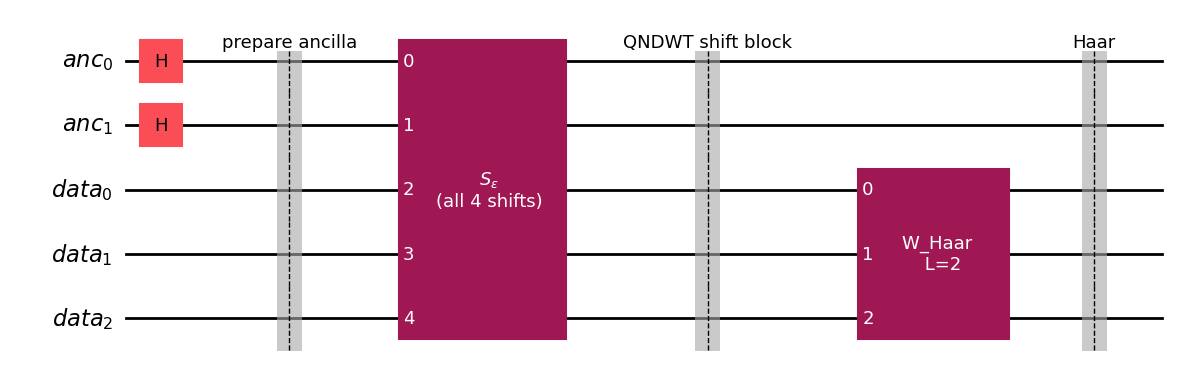

In [4]:
# 2) Single opaque gate representing all controlled circular shifts
#    This is just for drawing; we never simulate this circuit.
S_QND = Gate(name="$S_\epsilon$ \n(all 4 shifts)", num_qubits=anc_p.size + data_p.size, params=[])
qc_pretty.append(S_QND, anc_p[:] + data_p[:])

qc_pretty.barrier(label="QNDWT shift block")

# 3) Single opaque 3-qubit gate for 2-level Haar on data
W2_gate = Gate(name="W_Haar \n L=2", num_qubits=data_p.size, params=[])
qc_pretty.append(W2_gate, data_p[:])

qc_pretty.barrier(label="Haar")

print("\nSchematic QNDWT circuit (text):")
print(qc_pretty.draw(fold=-1))

# Nice Matplotlib figure
fig=qc_pretty.draw(output="mpl", fold=-1)
fig.savefig("qndwt001.pdf", format="pdf", bbox_inches="tight")
fig.savefig("qndwt001.png", dpi=600, bbox_inches="tight")
plt.show()

## Inversion of the QNDWT: Classical vs Fully Quantum

The nondecimated wavelet transform (NDWT) is **redundant**:  
for a length-$N$ signal, the 2-level NDWT produces $3N$ coefficients  
($w_1$, $w_2$, $a_2$).  
Therefore the transform is not orthonormal and does not have a direct inverse.  
Instead, it forms a **tight frame** in the Haar case and a general frame in the  
non-Haar case.

### Fully Quantum Inverse (Conceptual)

In principle, a **fully quantum inverse NDWT** is possible:

1. The forward qNDWT circuit prepares the state  
   $$
   |\Psi\rangle
   = \frac{1}{2} \sum_{\varepsilon=0}^{3}
     |\varepsilon\rangle_{\text{anc}}
     \otimes
     W S_\varepsilon |y\rangle ,
   $$
   where $W$ is the 2-level Haar transform and $S_\varepsilon$ are circular shifts.

2. A corresponding **inverse** circuit could be built using  
   $$
   S_\varepsilon^{-1} = S_{(-\varepsilon \bmod N)}, \qquad
   W^{-1} = W^{T},
   $$
   applied in reverse order and controlled on the same ancilla register.

3. This would coherently undo all shifts and the Haar transform,  
   recovering $|y\rangle$ directly in the quantum data register.

However, the inverse qNDWT is **circuit-heavy**:

- It must uncompute the superposition over all shifts.  
- It must apply the inverse operations in a controlled manner.  
- It requires access to all NDWT coefficients inside the quantum device.  
- It becomes exponentially more complex as we increase the number of levels $L$.

Because of these **circuit initiation and resource constraints**, we do **not**  
implement the fully quantum inverse here.  
Instead, we adopt a **quantum-inspired classical inverse**, which cleanly reconstructs  
the signal once the quantum NDWT coefficients $(w_1^{(q)}, w_2^{(q)}, a_2^{(q)})$  
are extracted from the statevector.

---

## Classical (Quantum-Inspired) Inverse NDWT

The classical inverse uses the fact that NDWT is a **linear frame transform**:

$$
T: \mathbb{R}^N \longrightarrow \mathbb{R}^{3N}, \qquad
T y = [w_1, w_2, a_2].
$$

To invert, we build the **NDWT matrix**  
$$
T = 
\begin{bmatrix}
w_1(e_0) & w_1(e_1) & \cdots & w_1(e_{N-1}) \\\\
w_2(e_0) & w_2(e_1) & \cdots & w_2(e_{N-1}) \\\\
a_2(e_0) & a_2(e_1) & \cdots & a_2(e_{N-1})
\end{bmatrix},
$$
where $e_i$ are coordinate basis vectors.

The **Moore–Penrose pseudoinverse** provides a stable left-inverse:

$$
T^{\dagger} = (T^T T)^{-1} T^T .
$$

Then reconstruction is simply

$$
y_{\text{rec}} = T^{\dagger} 
\begin{bmatrix}
w_1^{(q)} \\\\
w_2^{(q)} \\\\
a_2^{(q)}
\end{bmatrix}.
$$

This is exactly what the notebook computes in:

```python
T_pinv = np.linalg.pinv(T)
y_rec = T_pinv @ c_q


In [5]:
# ============================================================
# Inverse NDWT from (w1_q, w2_q, a2_q)
# ============================================================

# 1) Forward NDWT as a function (same logic as we used for y, but now for an arbitrary vec)
def ndwt_forward_vec(vec, W, shifts=(0, 1, 2, 3)):
    """
    Given a length-N vector 'vec', compute NDWT coeffs (w1, w2, a2)
    using the same Haar+shifts+assembly as in the qNDWT example.
    """
    N = vec.size

    # Per-shift 2-level Haar coefficients
    a2_eps = {}
    d2_eps = {}
    d1_eps = {}

    for eps in shifts:
        S = circ_shift_matrix(N, eps)
        coeff = W @ (S @ vec)
        a2_eps[eps] = coeff[0:2].copy()
        d2_eps[eps] = coeff[2:4].copy()
        d1_eps[eps] = coeff[4:8].copy()

    # Assemble NDWT
    w1 = np.zeros(N, dtype=float)
    w2 = np.zeros(N, dtype=float)
    a2 = np.zeros(N, dtype=float)

    for eps in shifts:
        w1 += place_and_unshift(d1_eps[eps], stride=2, N=N, eps=eps) / 2.0  # j=1, factor 2^{-1/2}
        w2 += place_and_unshift(d2_eps[eps], stride=4, N=N, eps=eps)       # j=2
        a2 += place_and_unshift(a2_eps[eps], stride=4, N=N, eps=eps)

    return w1, w2, a2

# 2) Build the NDWT transform matrix T: 3N x N
#    Columns are NDWT of basis vectors e_i
N=8
T = np.zeros((3 * N, N), dtype=float)

for i in range(N):
    e = np.zeros(N, dtype=float)
    e[i] = 1.0
    w1_i, w2_i, a2_i = ndwt_forward_vec(e, W, shifts=(0, 1, 2, 3))
    T[:, i] = np.concatenate([w1_i, w2_i, a2_i])

# 3) Pseudoinverse of T (left inverse for the frame)
T_pinv = np.linalg.pinv(T)

# 4) Reconstruct y from quantum NDWT coefficients (w1_q, w2_q, a2_q)
c_q = np.concatenate([w1_q, w2_q, a2_q])
y_rec = T_pinv @ c_q

print("Original y (scaled):   ", np.round(y, 6))
print("Reconstructed y_rec:   ", np.round(y_rec, 6))
print("Reconstruction error ‖y_rec - y‖:", np.linalg.norm(y_rec - y))

# 5) (Optional) Map back to original dd (undo scaling to [-1,1])
dd_min = dd.min()
dd_max = dd.max()

dd_rec = ( (y_rec + 1.0) / 2.0 ) * (dd_max - dd_min) + dd_min

print("\nOriginal dd:           ", dd)
print("Reconstructed dd_rec:  ", np.round(dd_rec, 6))
print("‖dd_rec - dd‖:", np.linalg.norm(dd_rec - dd))

Original y (scaled):    [ 0.263158  0.157895  1.        0.052632  0.368421 -1.        0.263158
  0.473684]
Reconstructed y_rec:    [ 0.263158  0.157895  1.        0.052632  0.368421 -1.        0.263158
  0.473684]
Reconstruction error ‖y_rec - y‖: 3.106432988556278e-14

Original dd:            [  2.   1.   9.   0.   3. -10.   2.   4.]
Reconstructed dd_rec:   [  2.   1.   9.   0.   3. -10.   2.   4.]
‖dd_rec - dd‖: 2.938085620544862e-13
